## Coded by Frank Zhao

Confusion Matrix design referrence: DTrimarchi10 https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

#### To solve autofill not functioning in Jupyter Lab, use the code below

In [1]:
%config IPCompleter.use_jedi = False

### import packages and Data

In [33]:
import pandas as pd
import numpy as np 
# from os import path
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import datetime
import joblib
%matplotlib inline

In [3]:
imdb = pd.read_csv(".\data\IMDB.csv")

In [4]:
imdb.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### Data Preprocessing 

* First, we will train and test the model with the data without removing stopwords and lemmatization.

In [5]:
def data_preprocessing(df):
    df = df.copy()
    
    # Replace sentiment col to numeric data
    df['sentiment'] = np.where(df['sentiment']=="positive", 1, 0)
    
    # lower case reviews
    df['review'] = df['review'].str.lower()
    
    # remove <br>
    df['review']= df['review'].str.replace('<.*?>', "")
    
    # remove ' ,puncuation and symbols
    df['review'] = df['review'].str.replace("'", "")

    df['review'] = df['review'].str.replace("[^\w\s]"," ")    
    return df

* Second, we will train and test the model with removing stopwords and lemmatization.

In [6]:
def data_preprocessing_lemma(df):
    df = df.copy()
    
    # load stopwords
    with open(".\data\Exports\master_sw.data", "rb") as file:
        master_sw = set(pickle.load(file))

    # Replace sentiment col to numeric data
    df['sentiment'] = np.where(df['sentiment']=="positive", 1, 0)
    
    # lower case reviews
    df['review'] = df['review'].str.lower()
    
    # remove <br>
    df['review']= df['review'].str.replace('<.*?>', "")
    
    # remove ' ,puncuation and symbols
    df['review'] = df['review'].str.replace("'", "")

    df['review'] = df['review'].str.replace("[^\w\s]"," ")
    
    # remove stopwords
    df['review'] = df['review'].apply(lambda x: " ".join([word for word in x.split() if word not in master_sw]))
    
    # Lemmatization
    WNlemma = nltk.WordNetLemmatizer()
    df['review'] = df['review'].apply(lambda x: " ".join([WNlemma.lemmatize(word) for word in x.split()]))
    
    return df

In [7]:
%%time
data = data_preprocessing(imdb)
data

<ipython-input-5-715cfb2d8c58>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review']= df['review'].str.replace('<.*?>', "")
<ipython-input-5-715cfb2d8c58>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace("[^\w\s]"," ")


Wall time: 1.35 s


,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tec...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy ...,0
4,petter matteis love in the time of money is ...,1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,bad plot bad dialogue bad acting idiotic di...,0
49997,i am a catholic taught in parochial elementary...,0
49998,im going to have to disagree with the previous...,0


In [8]:
%%time
data_lm = data_preprocessing_lemma(imdb)
data_lm

<ipython-input-6-c9a845a30ded>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review']= df['review'].str.replace('<.*?>', "")
<ipython-input-6-c9a845a30ded>:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace("[^\w\s]"," ")


Wall time: 18.2 s


,review,sentiment
0,reviewer mentioned watching 1 oz episode youll...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically there family little boy jake think t...,0
4,petter matteis love time money visually stunni...,1
...,...,...
49995,thought movie right good job wasnt creative or...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary school nu...,0
49998,im going disagree previous comment maltin seco...,0


## Train_Test_Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data["review"],
                                                    data["sentiment"],
                                                    random_state = 42,
                                                    train_size = 0.8
                                                   )

X_lm_train, X_lm_test, y_lm_train, y_lm_test = train_test_split(data_lm["review"],
                                                    data_lm["sentiment"],
                                                    random_state = 42,
                                                    train_size = 0.8
                                                   )

## Transform training and testing data

In [10]:
def tfidf_transform(X_train, X_test, ngram=[1,1]):
    # Fit the CountCectorizer to the training data
    tfvect = TfidfVectorizer(ngram_range=(ngram[0], ngram[1])).fit(X_train)
    
    # Transform the documents in the training data to a document term matrix
    X_train_tf = tfvect.transform(X_train)  
    
    # Transform the documents in the training data to a document term matrix
    X_test_tf = tfvect.transform(X_test)  
    
    return X_train_tf, X_test_tf

In [91]:
with open(r".\export\data\NoLemma\SVM\train_1-1-nolem_tf.data", "rb") as f:
    load_test= pickle.load(f)

In [93]:
pd.DataFrame.sparse.from_spmatrix(load_test)

,0,1,2,3,4,5,6,7,8,9,...,100974,100975,100976,100977,100978,100979,100980,100981,100982,100983
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## GridSearchCV

In [12]:
param_grid = {"C":[1, 10],
              "gamma":[0.01, 0.1],
              "kernel":["linear", "rbf"]
             }

svm_grid = GridSearchCV(SVC(), param_grid=param_grid, verbose=3, n_jobs=-1)

In [13]:
# %%time
# svm_grid.fit(X_train_cv, y_train)


### Save model

In [14]:
# joblib.dump(svm_grid, r".\export\data\NoLemma\SVM\svm_grid_1-1_cv.pkl")

In [15]:
ngrams = [[2,2], [3,3]]


In [16]:
def svm_grid(n_gram, X_train, y_train, param_grid):
            
        # Apply grid search
        svm_grid = GridSearchCV(SVC(), param_grid=param_grid, verbose=3, n_jobs=-1)
        
        # fit training data
        svm_grid.fit(X_train, y_train)
        
        # save model
        joblib.dump(svm_grid, r".\export\data\NoLemma\SVM\svm_grid_{}-{}_tf.pkl".format(n_gram[0], n_gram[1]))

In [17]:
def save_transform_data(X_train, X_test, ngram, lemma=False):
    
    # transform_data
    X_train_tf, X_test_tf = tfidf_transform(X_train, X_test, ngram=ngram)
    
    
    if lemma:
        # save tranform data
        filename_train = r".\export\data\Lemma\SVM\train_{}-{}-lem_tf.data".format(ngram[0], ngram[1])
        outtrain = open(filename_train, "wb")
        pickle.dump(X_train_tf, outtrain)
        outtrain.close()

        filename_test = r".\export\data\Lemma\SVM\test_{}-{}-lem_tf.data".format(ngram[0], ngram[1])
        outtest = open(filename_test, "wb")
        pickle.dump(X_test_tf, outtest)
        outtest.close()         

    else:
        # save tranform data
        filename_train = r".\export\data\NoLemma\SVM\train_{}-{}-nolem_tf.data".format(ngram[0], ngram[1])
        outtrain = open(filename_train, "wb")
        pickle.dump(X_train_tf, outtrain)
        outtrain.close()

        filename_test = r".\export\data\NoLemma\SVM\test_{}-{}-nolem_tf.data".format(ngram[0], ngram[1])
        outtest = open(filename_test, "wb")
        pickle.dump(X_test_tf, outtest)
        outtest.close()
        
    return X_train_tf, X_test_tf

*  Train without lemma

In [34]:
%%time
for ngram in ngrams:

    # get transform data
    X_train_tf, X_test_tf = save_transform_data(X_train, X_test, ngram, lemma=False)
    
    start = datetime.datetime.now()
    # apply grid search
    svm_grid(ngram, X_train_tf, y_train, param_grid)
    
    print("Finish {} gram".format(ngram))
    print("Time consuming: ", (datetime.datetime.now() - start))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Finish [2, 2] gram
Time consuming:  8:26:38.781937
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Finish [3, 3] gram
Time consuming:  10:34:58.588129
Wall time: 19h 2min 52s


** **

### Testing model

* Load model

In [36]:
svm_grid_1_1_tf = joblib.load(r".\export\data\NoLemma\SVM\svm_grid_1-1_tf.pkl", "r")
svm_grid_2_2_tf = joblib.load(r".\export\data\NoLemma\SVM\svm_grid_2-2_tf.pkl", "r")
svm_grid_3_3_tf = joblib.load(r".\export\data\NoLemma\SVM\svm_grid_3-3_tf.pkl", "r")

* check the grid search results

In [60]:
def show_results(svm_grid):
    
    # show cv results in df
    cvres = svm_grid.cv_results_
    grid_rf_df = pd.DataFrame({
        "Train_error": cvres["mean_test_score"],
        "Tuning_set": cvres["params"]
    }).sort_index()
    
    pd.set_option("display.max_colwidth", None)
    
    df = grid_rf_df.sort_values(by="Train_error", ascending=False).reset_index(drop=True)
    
    # show the best parameter
    best = svm_grid.best_estimator_
    
    return df, best

In [87]:
class clfrMeasure:
    # AUC score
    def auc(self, y_test, predict_labels):
        return roc_auc_score(y_test, predict_labels)
    
    # roc curve
    def roc_curve(self, y_test, predict_labels):
        return roc_curve(y_test, predict_labels)
    
    # accuracy
    def accuracy(self, y_test, predict_labels):
        return accuracy_score(y_test, predict_labels)
    
    # precision
    def precision(self, y_test, predict_labels):
        return precision_score(y_test, predict_labels)
    
    # recall
    def recall(self, y_test, predict_labels):
        return recall_score(y_test, predict_labels)

    # F1
    def f1(self, y_test, predict_labels):
        return f1_score(y_test, predict_labels)

    
    def evaluation(self, y_test, predict_labels, method):
            # Evaluation
        measure = {"accuracy": self.accuracy(y_test, predict_labels), 
                   "precision": self.precision(y_test, predict_labels), 
                   "recall": self.recall(y_test, predict_labels), 
                   "f1": self.f1(y_test, predict_labels),
                   "AUC": self.auc(y_test, predict_labels)
                  }
        # create a dictionary to gather evaluation results
        eva_results = {}
        
        # loop for each measure
        for m in method:
            eva_results[m] = float("{:.4f}".format(measure[m]))

        return eva_results
        
    # plot confusion matrix
    def confusion_matrix(self, y_test, predict_labels, ngram, clfr, tf = True, lemma=False):
        if tf:
            if lemma:
                fileDir = r".\export\images\Confusion_Matrix\Lemma_sw\{}\{}_tf_{}.png".format(clfr, clfr, ngram)
            else:
                fileDir = r".\export\images\Confusion_Matrix\No_Lemma_sw\{}\{}_tf_{}.png".format(clfr, clfr, ngram)
        else:    
            if lemma:
                fileDir = r".\export\images\Confusion_Matrix\Lemma_sw\{}\{}_cv_{}.png".format(clfr, clfr, ngram)
            else:
                fileDir = r".\export\images\Confusion_Matrix\No_Lemma_sw\{}\{}_cv_{}.png".format(clfr, clfr, ngram)
        
        # generate confusion matrix
        cm = confusion_matrix(y_test, predict_labels)
        
        # Get TP, FP, TN, FN labels
        TN = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TP = cm[1][1]
        
        # Comput stats
        accuracy = (TP+TN)/np.sum(cm)
        
        precision = TP/(TP+FP)
        
        recall = TP/(TP+FN)
        
        F1 = 2*precision*recall/(precision+recall)
        
        # set stat info to xlabel
        stat_info = "\n\nAccuracy={:0.4f}\nPrecision={:0.4f}\nRecall={:0.4f}\nF1 Score={:0.4f}".format(accuracy,
                                           precision,
                                           recall,
                                           F1
                                          )
        
        # Set TP, FP, TN, FN labels
        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        
        # Set format for each session
        group_counts = ["{0:0.0f}".format(value) for value in
                        cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                             cm.flatten()/np.sum(cm)]
        
        # Change label display
        labels = ["Negative", "Positive"]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        
        # show plot
        plt.figure(figsize=(20,20))
        sns.set(font_scale = 2)
        sns.heatmap(cm, 
                    annot=labels, 
                    fmt="", 
                    cmap=sns.color_palette("Paired"),
                    annot_kws={"size":35}
                   )
        if tf:
            if lemma:
                plt.title("Consusion matrix of {} {} Lemma Tfidf".format(clfr, ngram), fontsize= 35)
            else:
                plt.title("Consusion matrix of {} {} NoLemma Tfidf".format(clfr, ngram), fontsize= 35)
        else:
            if lemma:
                plt.title("Consusion matrix of {} {} Lemma cv".format(clfr, ngram), fontsize= 35)
            else:
                plt.title("Consusion matrix of {} {} NoLemma cv".format(clfr, ngram), fontsize= 35)
        plt.xlabel("Predicted" + stat_info, fontsize= 20)
        plt.ylabel("Actual", fontsize= 20)
        plt.savefig(fileDir)
        plt.show()


In [68]:
def load_data(direct, filename):
    path = r"{}{}".format(direct, filename)
    
    with open(path, "rb") as f:
        load_f = pickle.load(f)
    return load_f

** **
+ Unigram

In [61]:
grid_rf_df1_1, best_estimator1_1 = show_results(svm_grid_1_1_tf)
grid_rf_df1_1

,Train_error,Tuning_set
0,0.897425,"{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}"
1,0.897425,"{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}"
2,0.896825,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}"
3,0.890550,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}"
4,0.888400,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}"
5,0.879375,"{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}"
6,0.879375,"{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}"
7,0.820025,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}"


In [39]:
best_estimator1_1

SVC(C=1, gamma=0.01, kernel='linear')

* Test Model


In [73]:
test_1_1_nolem_tf = load_data(r".\export\data\NoLemma\SVM\\","test_1-1-nolem_tf.data")

In [75]:
%%time
svm_prediction1_1 = svm_grid_1_1_tf.predict(test_1_1_nolem_tf)
svm_prediction1_1

Wall time: 2min 39s


memmap([0, 1, 0, ..., 1, 0, 1])

In [81]:
## save prediction results
with open(r".\export\data\NoLemma\SVM\predict_nolem_tf_1_1.data", "wb") as f:
    pickle.dump(svm_prediction1_1, f)

* Plot Confusion Matrix

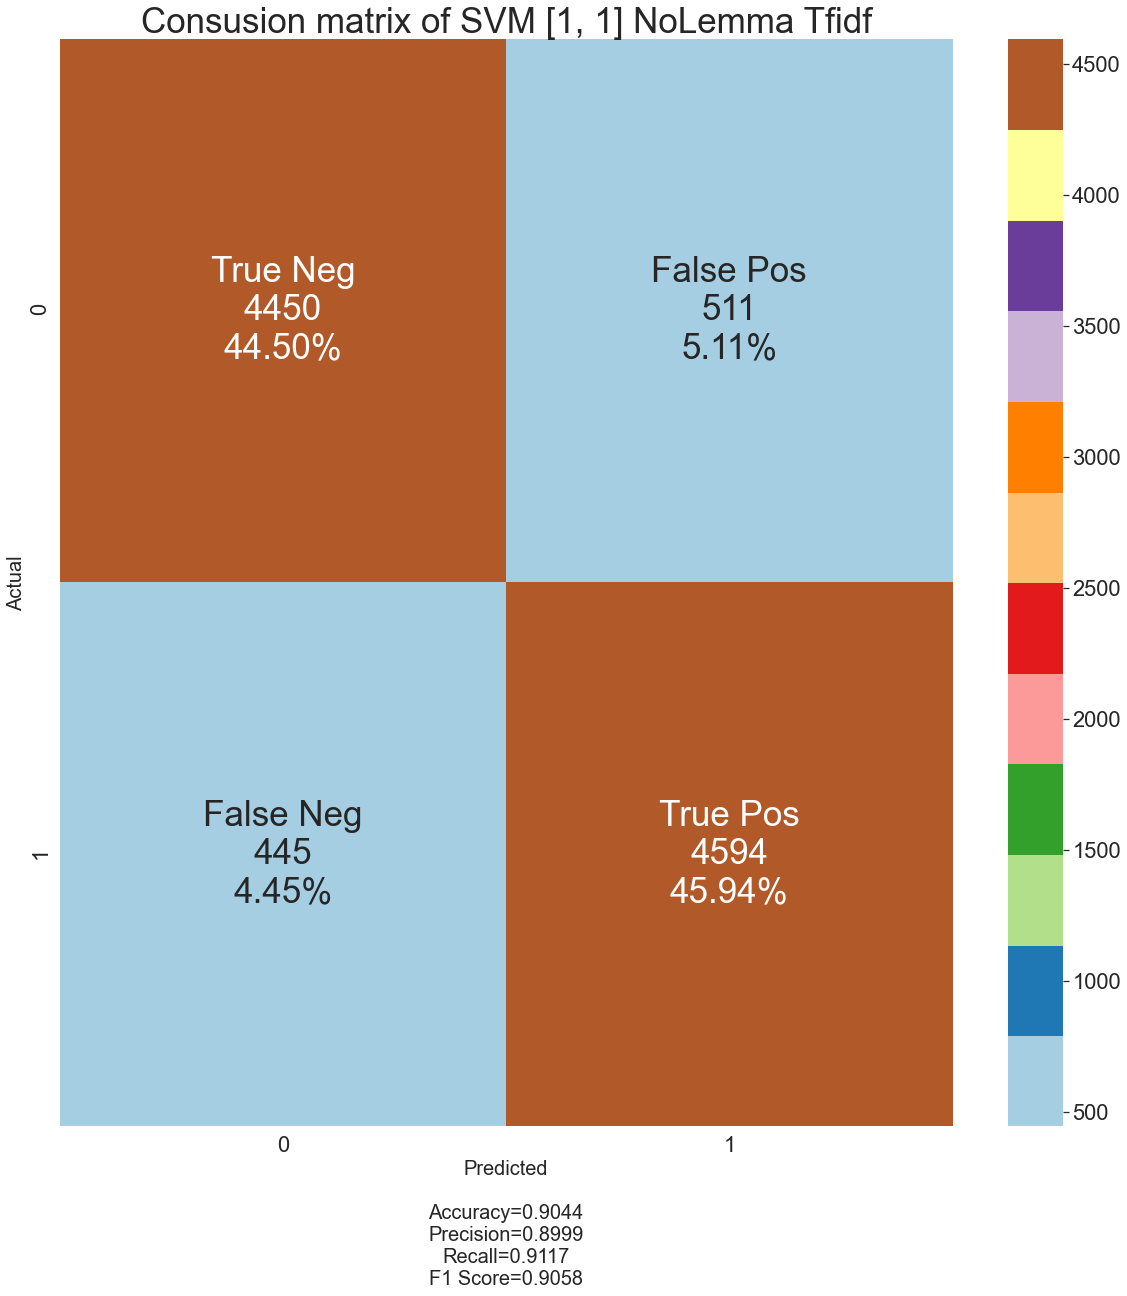

In [88]:
clfrMeasure().confusion_matrix(y_test, svm_prediction1_1, [1,1], "SVM", tf = True, lemma=False)

** **
* Bigram

In [62]:
grid_rf_df2_2, best_estimator2_2 = show_results(svm_grid_2_2_tf)
grid_rf_df2_2

,Train_error,Tuning_set
0,0.900475,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}"
1,0.899800,"{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}"
2,0.899800,"{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}"
3,0.899475,"{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}"
4,0.899475,"{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}"
5,0.864200,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}"
6,0.856925,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}"
7,0.501275,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}"


In [63]:
best_estimator2_2

SVC(C=10, gamma=0.1)

* Test Model


In [77]:
test_2_2_nolem_tf = load_data(r".\export\data\NoLemma\SVM\\","test_2-2-nolem_tf.data")

In [78]:
%%time
svm_prediction2_2 = svm_grid_2_2_tf.predict(test_2_2_nolem_tf)
svm_prediction2_2

Wall time: 6min 46s


memmap([1, 1, 0, ..., 1, 0, 1])

In [82]:
## save prediction results
with open(r".\export\data\NoLemma\SVM\predict_nolem_tf_2_2.data", "wb") as f:
    pickle.dump(svm_prediction2_2, f)

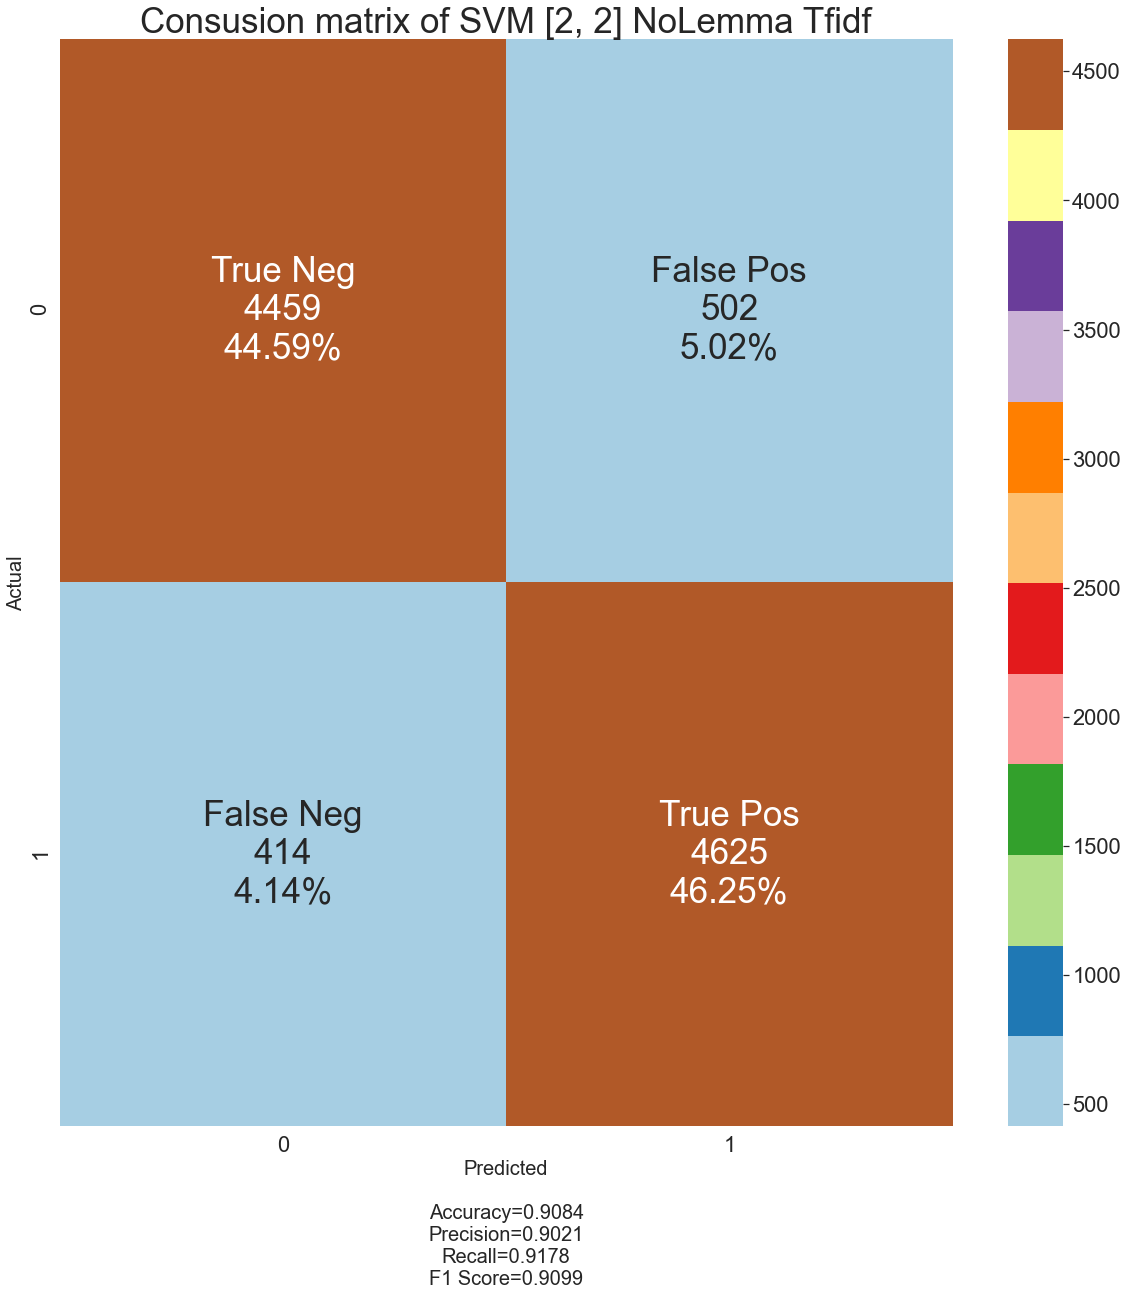

In [89]:
clfrMeasure().confusion_matrix(y_test, svm_prediction2_2, [2,2], "SVM", tf = True, lemma=False)

** **
* Trigram

In [64]:
grid_rf_df3_3, best_estimator3_3 = show_results(svm_grid_3_3_tf)
grid_rf_df3_3

,Train_error,Tuning_set
0,0.867750,"{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}"
1,0.867750,"{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}"
2,0.865875,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}"
3,0.864200,"{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}"
4,0.864200,"{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}"
5,0.812450,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}"
6,0.792075,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}"
7,0.500975,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}"


In [65]:
best_estimator3_3

SVC(C=10, gamma=0.01, kernel='linear')

* Test Model


In [79]:
test_3_3_nolem_tf = load_data(r".\export\data\NoLemma\SVM\\","test_3-3-nolem_tf.data")

In [80]:
%%time
svm_prediction3_3 = svm_grid_3_3_tf.predict(test_3_3_nolem_tf)
svm_prediction3_3

Wall time: 6min 21s


memmap([1, 0, 0, ..., 1, 0, 1])

In [83]:
## save prediction results
with open(r".\export\data\NoLemma\SVM\predict_nolem_tf_3_3.data", "wb") as f:
    pickle.dump(svm_prediction3_3, f)

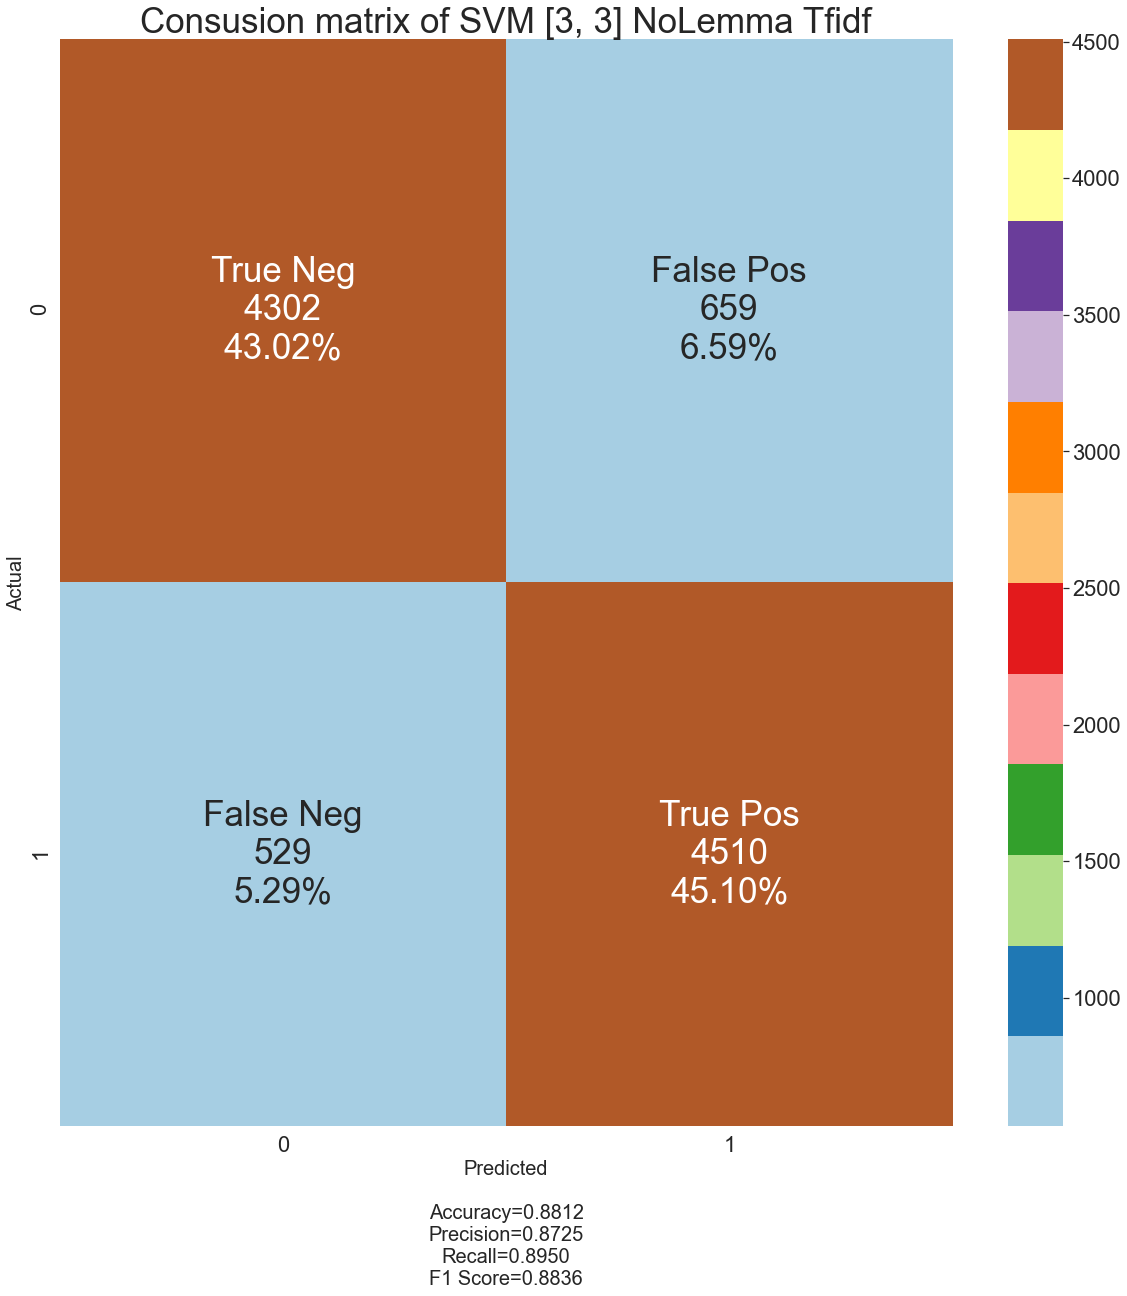

In [90]:
clfrMeasure().confusion_matrix(y_test, svm_prediction3_3, [3,3], "SVM", tf = True, lemma=False)